# ESP Virtual Flow Metering using XGBoost
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

**Objective:** Develop a Virtual Flow Meter (VFM) to estimate Liquid Rate (BPD) using standard ESP sensor data.  
**Algorithm:** XGBoost Regressor (Gradient Boosting).

## 1. Import Libraries
We will use Pandas for data manipulation, Matplotlib/Seaborn for visualization, and XGBoost for modeling.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configuration for prettier plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Load and Inspect Data
We load the dataset `esp_vfm_data.csv`. 

**Feature Dictionary:**
* `pump_frequency_hz`: ESP Drive Frequency.
* `intake_pressure_psi`: Pressure at pump intake.
* `discharge_pressure_psi`: Pressure at pump discharge.
* `liquid_rate_bpd`: **Target Variable** (Liquid production rate).

In [4]:
# Load Data
df = pd.read_csv('esp_vfm_data.csv')

# Display first 5 rows
print(df.head())

# Check data statistics
print("\nData Description:")
print(df.describe())

   pump_frequency_hz  intake_pressure_psi  discharge_pressure_psi  \
0               41.2                504.7                   851.5   
1               58.5                498.8                   944.6   
2               52.0                762.5                  1159.6   
3               48.0                499.8                  1291.6   
4               34.7                508.8                   904.8   

   liquid_rate_bpd  
0           1561.6  
1           2523.6  
2           2187.7  
3           1365.1  
4            983.5  

Data Description:
       pump_frequency_hz  intake_pressure_psi  discharge_pressure_psi  \
count        2000.000000          2000.000000             2000.000000   
mean           44.959150           598.557050             1078.474150   
std             8.766395           115.431766              298.073654   
min            30.100000           400.000000              472.600000   
25%            37.100000           500.350000              855.750000   
50

## 3. Feature Engineering & EDA
Before training, we should visualize the relationships. 

A key physical parameter for pumps is **Differential Pressure (Diff P)**, also known as Head (in psi).
$$\text{Diff P} = \text{Discharge Pressure} - \text{Intake Pressure}$$

We will create this feature to help the model learn the physics easier.

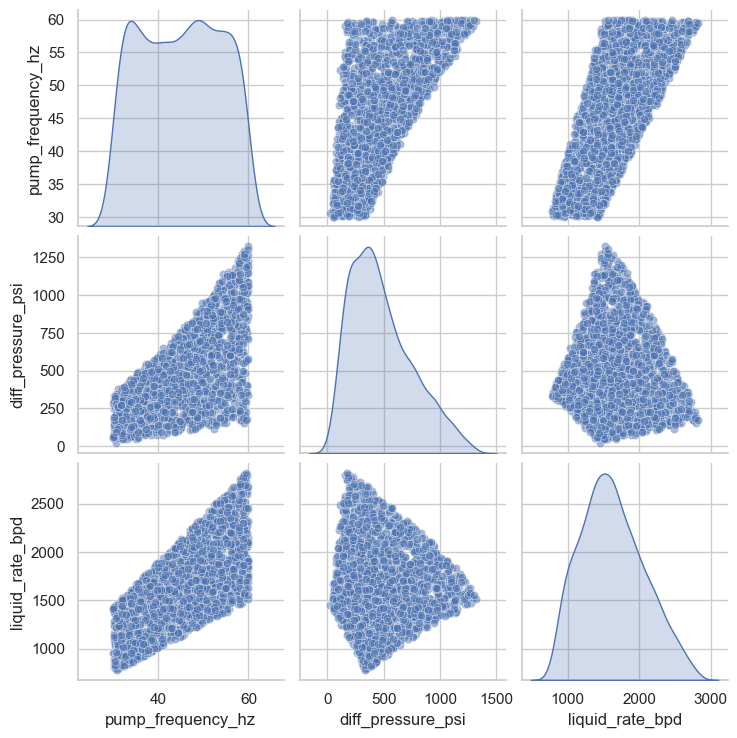

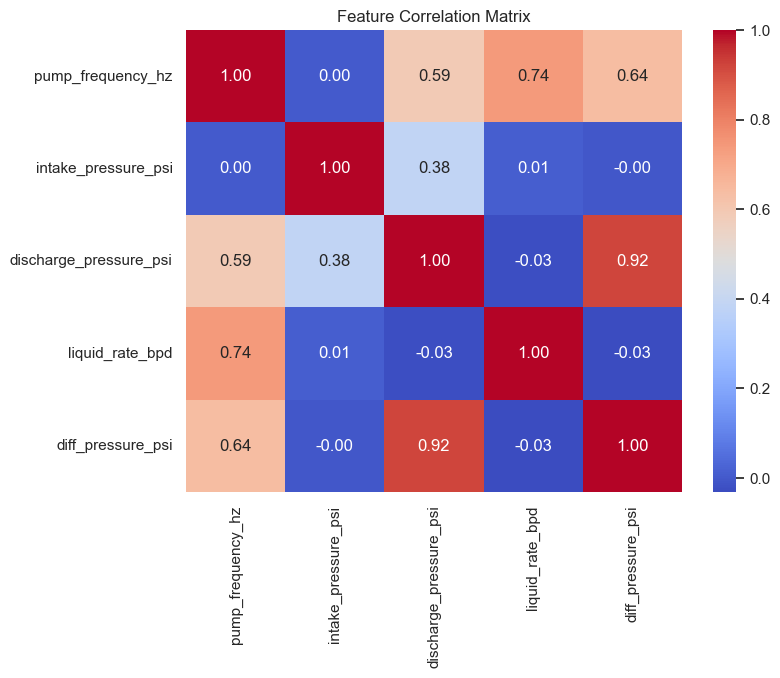

In [5]:
# Feature Engineering: Calculate Differential Pressure
df['diff_pressure_psi'] = df['discharge_pressure_psi'] - df['intake_pressure_psi']

# Visualization: Pairplot to see correlations
# We expect a strong relationship between Frequency, Diff P, and Rate
sns.pairplot(df, 
             vars=['pump_frequency_hz', 'diff_pressure_psi', 'liquid_rate_bpd'], 
             diag_kind='kde',
             plot_kws={'alpha': 0.5})
plt.show()

# Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## 4. Train/Test Split
We split the data into training (80%) and testing (20%) sets to evaluate how well our VFM generalizes to unseen data.

In [6]:
# Define Features (X) and Target (y)
features = ['pump_frequency_hz', 'intake_pressure_psi', 'discharge_pressure_psi', 'diff_pressure_psi']
target = 'liquid_rate_bpd'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1600, 4)
Testing shape: (400, 4)


## 5. Model Training (XGBoost)
We use the `XGBRegressor`. 

**Why XGBoost?**
ESP pump curves are non-linear. XGBoost is excellent at capturing these non-linear boundaries without requiring complex data scaling (normalization) like Neural Networks do.

In [7]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

print("Model Training Completed.")

Model Training Completed.


## 6. Model Evaluation
We evaluate performance using:
1.  **RMSE (Root Mean Squared Error):** Average error in BPD.
2.  **R² Score:** Goodness of fit (closer to 1.0 is better).
3.  **Cross-plot:** Predicted vs Actual values.

Root Mean Squared Error (RMSE): 35.98 BPD
R^2 Score: 0.9933


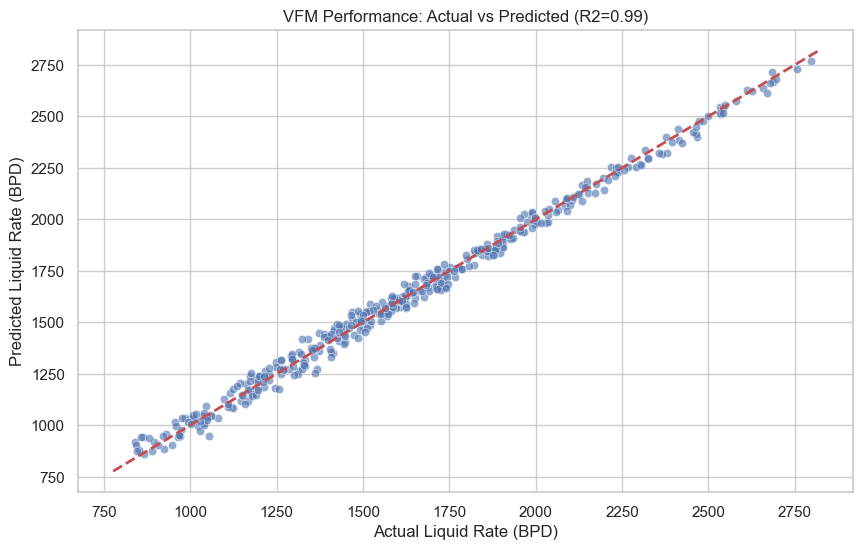

In [8]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} BPD")
print(f"R^2 Score: {r2:.4f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Liquid Rate (BPD)')
plt.ylabel('Predicted Liquid Rate (BPD)')
plt.title(f'VFM Performance: Actual vs Predicted (R2={r2:.2f})')
plt.show()

## 7. Feature Importance
Which sensor has the most impact on calculating the flow rate? This helps in explainability.

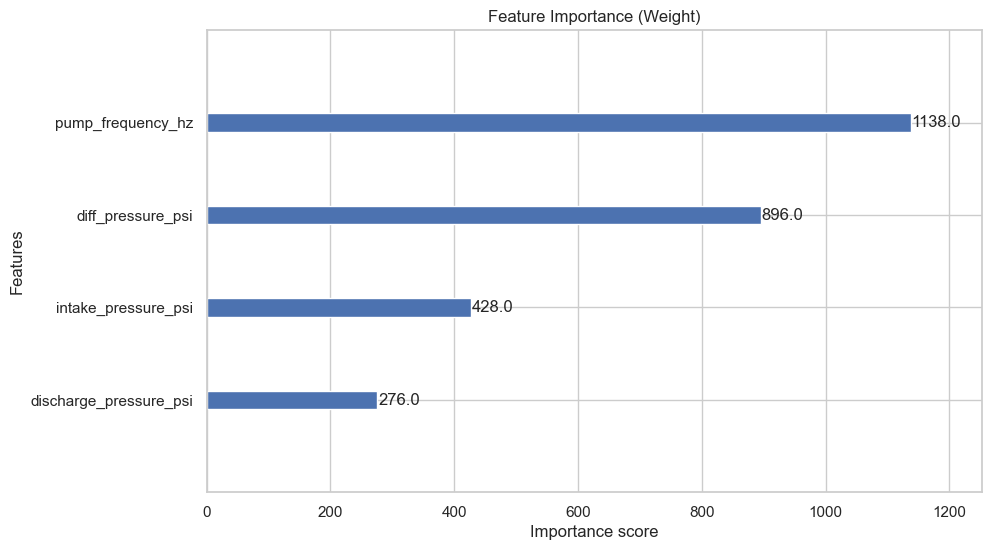

In [9]:
# Plot Feature Importance
xgb.plot_importance(model, importance_type='weight', title='Feature Importance (Weight)')
plt.show()